In [1]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [ ]:
!pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

In [10]:
import torch
import tensorflow
import os

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import set_global_seed, tournament
from rlcard.utils import Logger

# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from models import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn

from DQNAgent_pytorch import DQNAgent

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis/dqn
/content/drive/My Drive/Colab Notebooks/Thesis


# DQN Models

## all_states_all_actions

### Parameters

In [44]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = 'all_states_all_actions'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [45]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP_base(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)

### Environment Initialization

In [46]:
from tensorflow.keras.backend import clear_session
clear_session()

In [47]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [48]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)

In [49]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=110, bias=True)
  (4): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  0.18599999999999972
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.42462486028671265
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.35666120052337646
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.46394774317741394
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.26728540658950806
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4685, rl-loss: 0.29888513684272766
----------------------------------------
  timestep     |  9347
  reward       |  0.18779999999999977
----------------------------------------
INFO - Agent dqn, step 5000, rl-loss: 0.3649541437625885
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6000, rl-loss: 0.3121812641620636
INFO - Copied model parameters to target network.
INFO - Age

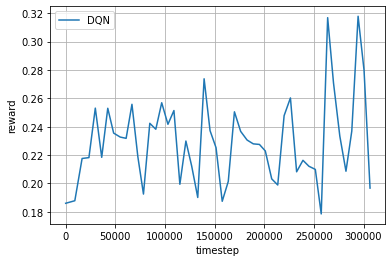

In [50]:
# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
print(state_dict.keys())
torch.save(state_dict, os.path.join(save_dir, 'model.pth'))

## all_states_all_actions_2hl_extra_knock_data_40K

### Parameters

In [51]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 5000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

In [52]:
torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

MLP_2HL(
  (l1): Linear(in_features=260, out_features=520, bias=True)
  (l2): Linear(in_features=520, out_features=520, bias=True)
  (l3): Linear(in_features=520, out_features=110, bias=True)
  (act_fnc): Sigmoid()
  (sfx): Softmax(dim=1)
)

### Environment Initialization

In [53]:
from tensorflow.keras.backend import clear_session
clear_session()

In [54]:
# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}/{}'.format(state,action,model_name)

# Set a global seed
set_global_seed(0)

agent = DQNAgent(scope='dqn',
                 action_num=env.action_num,
                 replay_memory_init_size=memory_init_size,
                 train_every=train_every,
                 state_shape=env.state_shape,
                 mlp_layers=[520, 520],
                 device=device)
    # def __init__(self,
    #              scope,
    #              replay_memory_size=20000,
    #              replay_memory_init_size=100,
    #              update_target_estimator_every=1000,
    #              discount_factor=0.99,
    #              epsilon_start=1.0,
    #              epsilon_end=0.1,
    #              epsilon_decay_steps=20000,
    #              batch_size=32,
    #              action_num=2,
    #              state_shape=None,
    #              train_every=1,
    #              mlp_layers=None,
    #              learning_rate=0.00005,
    #              device=None)

random_agent = RandomAgent(action_num=eval_env.action_num)
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])

# Init a Logger to plot the learning curve
logger = Logger(log_dir)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [55]:
model = torch.load('{}/models/{}/{}/{}/model.pt'.format(pth,state,action,model_name), map_location=device)

# load pretrained weights
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l2.bias)

In [56]:
agent.q_estimator.qnet.fc_layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=260, out_features=520, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=520, out_features=520, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=520, out_features=110, bias=True)
  (6): Softmax(dim=1)
)

### Train


----------------------------------------
  timestep     |  136
  reward       |  0.20679999999999968
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.34822678565979004
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.5819202661514282
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.5173667073249817
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.37212714552879333
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4484, rl-loss: 0.4371311664581299
----------------------------------------
  timestep     |  8940
  reward       |  0.25059999999999966
----------------------------------------
INFO - Agent dqn, step 5000, rl-loss: 0.3787386417388916
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 6000, rl-loss: 0.34643125534057617
INFO - Copied model parameters to target network.
INFO - Agent

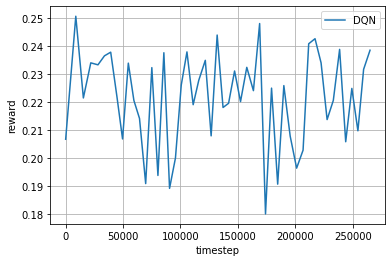

In [57]:
# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance. Play with random agents.
    if episode % evaluate_every == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
save_dir = 'models/dqn/{}/{}/{}'.format(state,action,model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
print(state_dict.keys())
torch.save(state_dict, os.path.join(save_dir, 'model.pth'))